In [19]:
from HBV_bmi import HBV
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy
import random

rng = np.random.default_rng() # Initiate a Random Number Generator

In [20]:
df_in = pd.read_csv("Forcing.txt", delimiter="	", names=["year","month","day","P","Q","EP"])
df_in.index = df_in.apply(lambda x: pd.Timestamp(f'{int(x.year)}-{int(x.month)}-{int(x.day)}'),axis=1)
df_in.drop(columns=["year","month","day","P","EP"],inplace=True)
df = df_in # just need observations to compare to

In [21]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [22]:
config_file = f"""{{
    "forcing_file": "Forcing.txt",
    "parameters": "{','.join([str(p) for p in par_0])}",
    "initial_storage":"{','.join([str(s) for s in s_0])}",
    "timestep": 1
}}
"""

with open("HBV_config.json", "w") as f:
    f.write(config_file)

In [23]:
model = HBV()
model.initialize(config_file="HBV_config.json")

In [24]:
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))

**compare to previous implemented model**

In [25]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

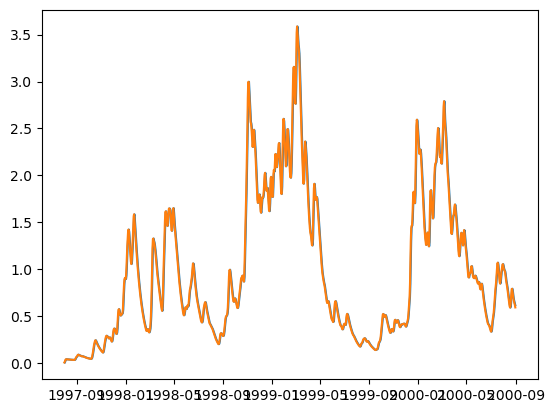

In [26]:
plt.plot(time, Q_m)
plt.plot(model.df.index, Q_m_in_ref);
# basically identical

In [27]:
n_particles = 10

In [28]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [29]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

In [30]:
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []
    ensembleMember.storage_terms_lst = []

In [31]:
model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))
        ensembleMember.storage_terms_lst.append(ensembleMember.get_value("storage_terms",np.zeros(4)))

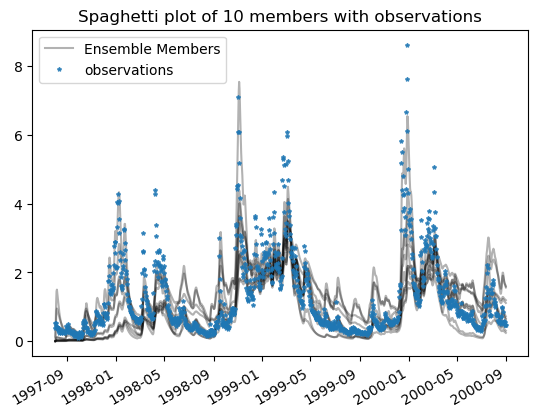

In [32]:
# plt.plot(time, Q_m,zorder=100,color="C3")
plt.title(f"Spaghetti plot of {n_particles} members with observations")
for index, ensembleMember in enumerate(ensemble[:-1]):
        plt.plot(time, ensembleMember.Q_m_list,color='k',alpha=0.3)
plt.plot(time, ensemble[-1].Q_m_list,color='k',alpha=0.3,label="Ensemble Members")
plt.xticks(rotation=90);
df.Q.plot(marker="*",lw=0, markersize=3, label="observations",alpha=0.8);
plt.legend();

Extract the storage terms (for adding reasonable noise later)

In [33]:
storage_terms = []
for ensembleMember in ensemble:
    storage_terms.append(np.array(ensembleMember.storage_terms_lst))
storage_terms = np.array(storage_terms)
storage_max = []

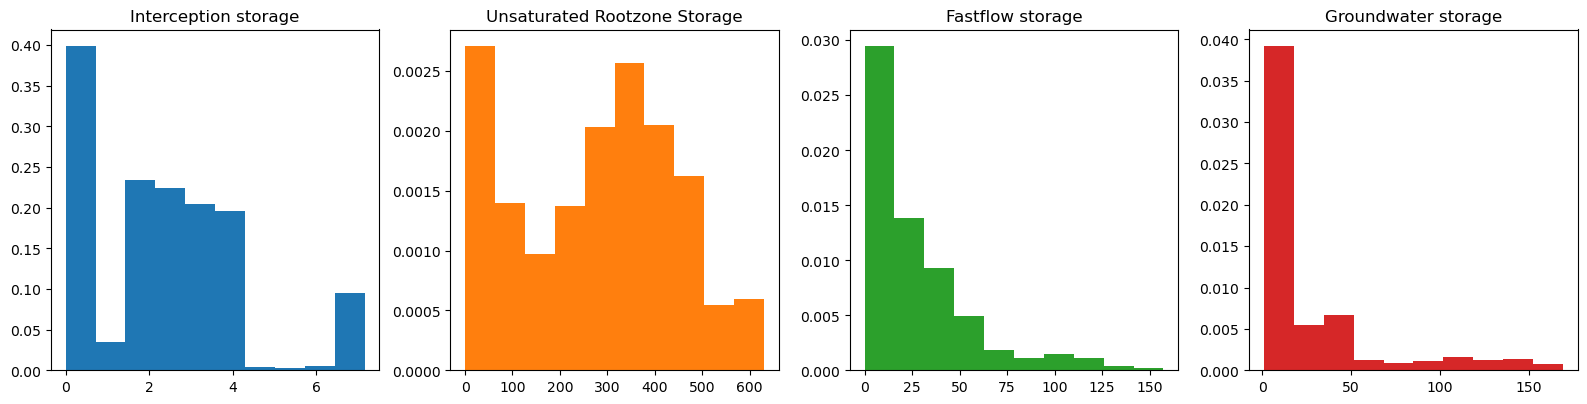

In [34]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
fig.tight_layout(w_pad=2)
for index, storage_type in enumerate(storage_terms.T):
    ax[index].hist(storage_type.flatten(),density=True,color=f'C{index}')
    ax[index].set_title(S_names[index])
    storage_max.append(max(storage_type.flatten()))

In [35]:
storage_max

[7.151205126319859, 630.497554261492, 157.26192994180226, 169.23884943466624]

# Just consider a few timesteps

In [17]:
n_particles = 500

In [18]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
t_inital = 870393600
n_days = 50
d_2_sec = 24*3600
while model.get_current_time() < t_inital + n_days * d_2_sec:
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

**Prior distribution of parameters can be represented**

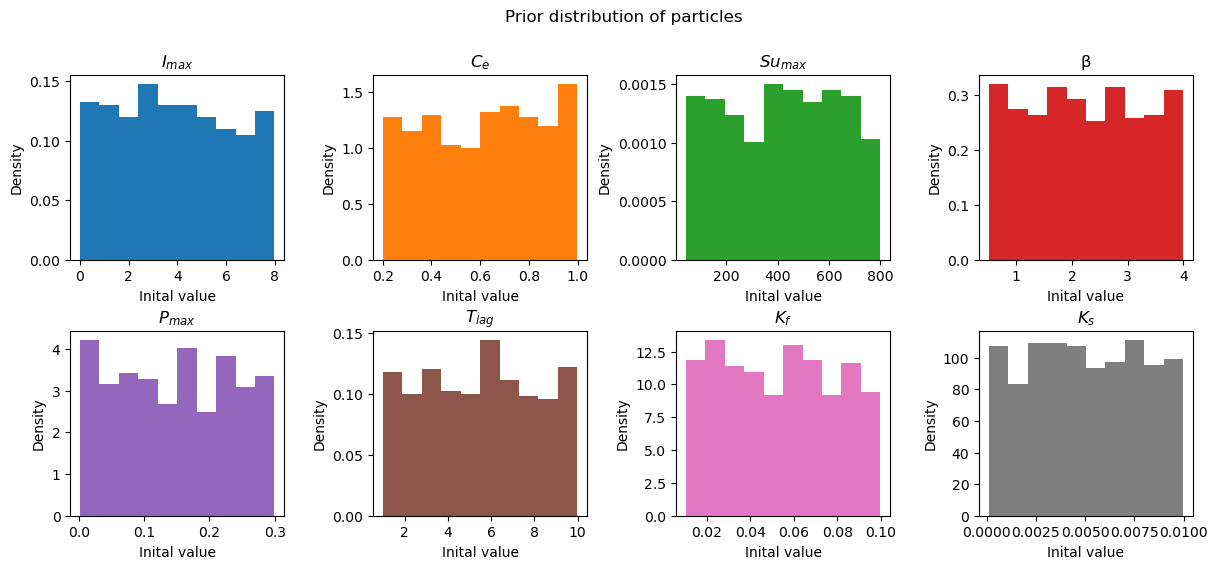

In [19]:
n_params = len(p_intial[0])
fig, ax = plt.subplots(2,n_params//2, figsize=(12,5))
fig.tight_layout(h_pad=3,w_pad=3)
fig.suptitle("Prior distribution of particles",y=1.09)
ax = ax.flatten()
for i in range(n_params):
    ax[i].hist(np.vstack(p_intial)[:,i],color=F"C{i}",density=True)
    # ax[i].bar(np.arange(1,n_particles+1,1),np.vstack(p_intial)[:,i], color=F"C{i}")
    # ax[i].set_xticks(np.arange(1,n_particles+1,1))
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Inital value")
    ax[i].set_title(p_names[i])

In [20]:
prior_Q = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble])

 needs about 30 day spin up time 😬

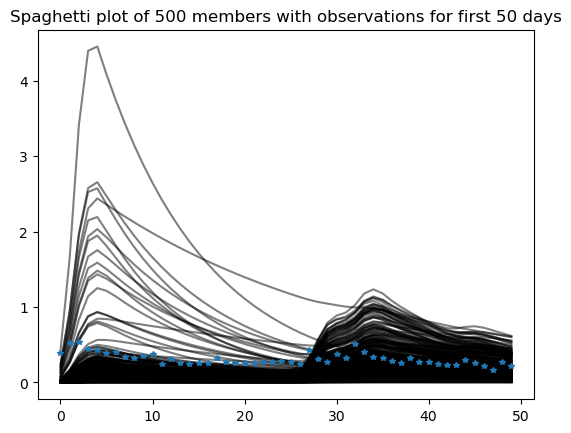

In [21]:
fig, ax = plt.subplots()
ax.set_title(f"Spaghetti plot of {n_particles} members with observations for first 50 days")
ax.plot(df.iloc[:n_days].Q.values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(ensembleMember.Q_m_list,color="k",alpha=0.5) for ensembleMember in ensemble];

# repeat but for full time span & investigate errors

In [22]:
n_particles = 500

In [23]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])

In [24]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
while model.get_current_time() <= model.get_end_time(): # must be equal to to match length of Obs
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

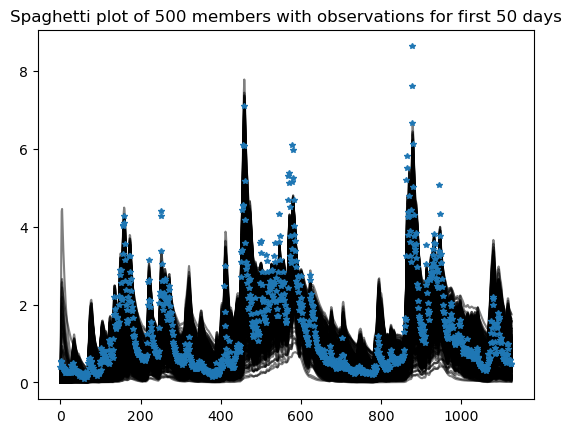

In [25]:
fig, ax = plt.subplots()
ax.set_title(f"Spaghetti plot of {n_particles} members with observations for first 50 days")
ax.plot(df.Q.values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(ensembleMember.Q_m_list,color="k",alpha=0.5) for ensembleMember in ensemble];

In [26]:
Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])

In [27]:
print(f'The mean of all ensemble values is {Q_all.mean():.3f} mm/d with a standard deviation of {Q_all.std():.3f} mm/d')
print(f'The mean of the observed values is {df.Q.mean():.3f} mm/d with a standard deviation of {df.Q.std():.3f} mm/d')

The mean of all ensemble values is 1.040 mm/d with a standard deviation of 0.867 mm/d
The mean of the observed values is 1.272 mm/d with a standard deviation of 1.181 mm/d


Look per ensemble member

In [28]:
lst_std = [Qm.flatten().std() for Qm in Q_all]

Instead use [NSE](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient)

In [46]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [30]:
lst_NSE = [calc_NSE(df.Q, Qm.flatten()) for Qm in Q_all]

plot both

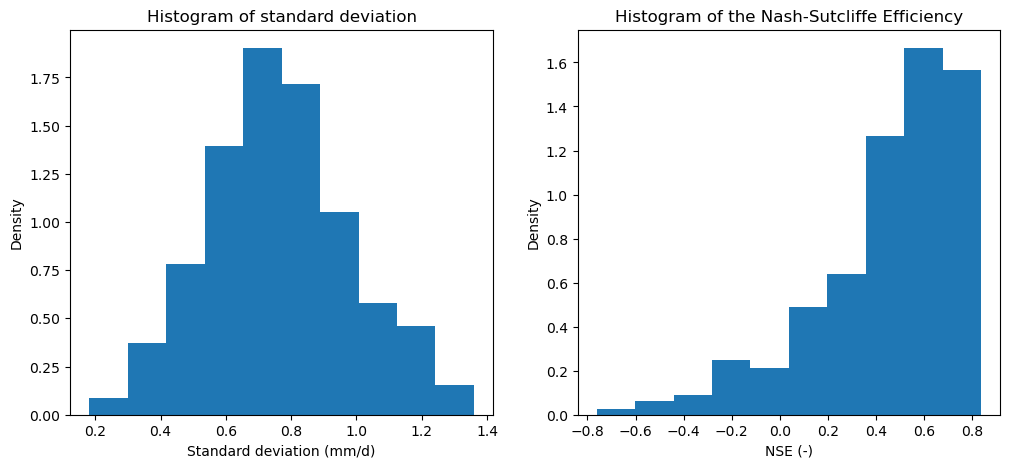

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(lst_std,density=True)
plt.title("Histogram of standard deviation")
plt.ylabel("Density")
plt.xlabel("Standard deviation (mm/d)");

plt.subplot(122)
plt.hist(lst_NSE,density=True)
plt.title("Histogram of the Nash-Sutcliffe Efficiency")
plt.ylabel("Density")
plt.xlabel("NSE (-)");

# investigate likelyhood, posterior etc

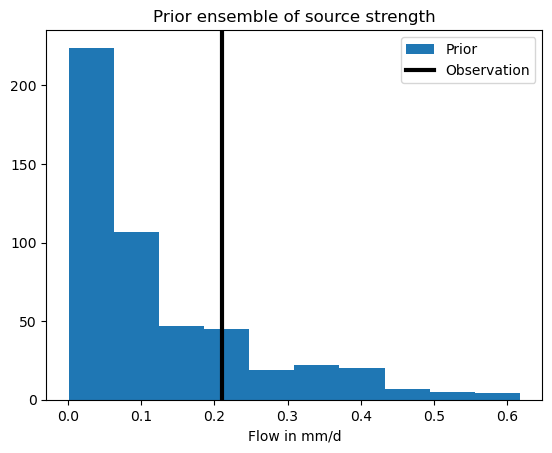

In [32]:
fig, ax = plt.subplots()
ax.hist(prior_Q, label='Prior')
ax.axvline(df.Q.iloc[n_days], c='k', lw=3, label='Observation')
ax.set_title('Prior ensemble of source strength')
ax.set_xlabel('Flow in mm/d')
ax.legend();

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

In [33]:
innov2 = (df.Q.iloc[n_days] - prior_Q)**2
like_sigma = 0.005  # In [m]; so 5 mm

In [34]:
unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))

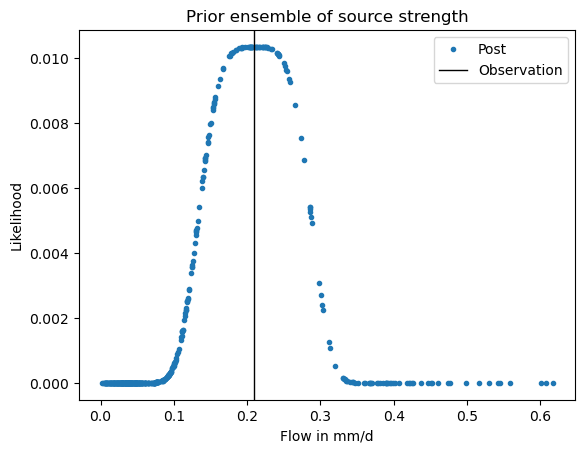

In [35]:
fig, ax = plt.subplots()
ax.plot(prior_Q, normalised_weights, label='Post',marker=".",lw=0)
ax.axvline(df.Q.iloc[n_days], c='k', lw=1, label='Observation')
ax.set_title('Prior ensemble of source strength')
ax.set_xlabel('Flow in mm/d')
ax.set_ylabel('Likelihood')
ax.legend();

Clearly see a peak of likelihood around the observation, the spread of observations isn't great yet however 

**rewrite loop to include above code**  <br>
try parralel computing

In [36]:
def generate_weights(ensemble, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble]) # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

In [37]:
n_particles = 500

In [39]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
model_times = []
t_inital = 870393600
n_days = 50
d_2_sec = 24*3600
while model.get_current_time() < t_inital + n_days * d_2_sec:
    # do an inital model run 
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    model_times.append(pd.Timestamp(model.get_current_time(), unit="s"))
    n = len(ensemble)

    # run each step for each member
    for index,ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

    # post processeing
    Q_obs = df.loc[pd.Timestamp(model.get_current_time(), unit="s"),"Q"]
    likelihood = generate_weights(ensemble, Q_obs)

Attempt parralel runs but doesn't fix it

In [40]:
# from numba import njit, prange

# @njit(parallel=True,cache=True)
# def run_model(n_particles):
#     # for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
#     np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
#     array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
#     p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
    
#     # set up ensemble
#     ensemble = []
#     for i in range(n_particles):
#         ensemble.append(HBV())
    
#     # run initialisation & set the parameters
#     for index, ensembleMember in enumerate(ensemble):
#         ensembleMember.initialize(config_file="HBV_config.json")
#         ensembleMember.set_pars(p_intial[index])
#         ensembleMember.Q_m_list = []
    
#     model = HBV()
#     model.initialize(config_file="HBV_config.json")

#     t_inital = 870393600
#     n_days = 50
#     d_2_sec = 24*3600
#     Q_m = np.zeros(n_days)
#     model_times = np.zeros(n_days)
#     # while model.get_current_time() < t_inital + n_days * d_2_sec:
#     for i in prange(n_days):
#         # do an inital model run 
#         model.update()
#         Q_m[i]         = model.get_value("Q_m", np.array([0.]))
#         model_times[i] = model.get_current_time()
#         n = len(ensemble)
    
#         # run each step for each member
#         for index,ensembleMember in enumerate(ensemble):
#             ensembleMember.update()
#             ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))
    
#         # post processeing
#         Q_obs = df.loc[pd.Timestamp(model.get_current_time(), unit="s"),"Q"]
#         post_Q, likelihood = generate_weights(ensemble, Q_obs)

Investigate likelihoods for the last step, no real patterns however,m but could be in 8D space

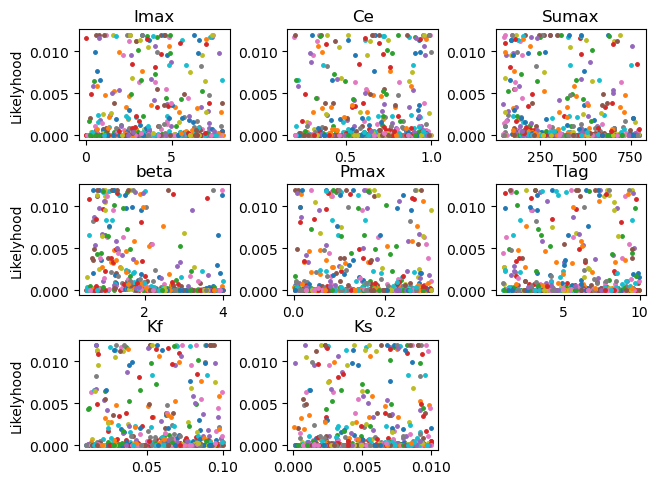

In [41]:
fig, ax = plt.subplots(3,3)
fig.tight_layout()
ax_index = ax.flatten()
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
set_title = True
for j, likelihood_j in enumerate(likelihood):
    for i in range(len(p_intial[0])):
        ax_index[i].plot(p_intial[j][i],likelihood_j, ".",markersize=5)
        if set_title: # only set it once
            ax_index[i].set_title(param_names[i])
            if i % 3 == 0:
                ax_index[i].set_ylabel("Likelyhood")
    set_title=False
ax_index[-1].axis('off'); # remove last one

Could also change how we sample the parameters at t=0

In [42]:
# n_params = len(p_intial[0])
# fig, ax = plt.subplots(2,n_params//2, figsize=(12,5))
# fig.tight_layout(h_pad=3,w_pad=3)
# fig.suptitle("Posterior distribution of parameters of particles with likelihood > 0.001",y=1.09)
# ax = ax.flatten()
# for i in range(n_params):
#     parameter_values_i = np.vstack(selected_p_values)[:,i]
#     ax[i].hist(parameter_values_i,color=F"C{i}",density=True)
#     ax[i].axvline(parameter_values_i.mean(),color="k")
#     # gaussian 
#     mhu, sig = scipy.stats.norm.fit(parameter_values_i)
#     x = np.linspace(parameter_values_i.min(),parameter_values_i.max())
#     y = scipy.stats.norm.pdf(x, mhu, sig)
#     ax[i].plot(x, y,color= "C9",alpha=0.4,label="normal")
    
#     # gumbel
#     a, b = scipy.stats.gumbel_r.fit(parameter_values_i)
#     x = np.linspace(parameter_values_i.min(),parameter_values_i.max())
#     y = scipy.stats.gumbel_r.pdf(x, a, b)
#     ax[i].plot(x, y,color= "grey",label="gumbel",alpha=0.5)
    
#     ax[i].set_ylabel("Density")
#     ax[i].set_xlabel("Inital value")
#     ax[i].set_title(p_names[i])

# ax[-1].legend();

    # likelihood_thousandths = likelihood>0.001 ### remove this 
    # selected_p_values = p_intial[likelihood_thousandths.flatten()] # only take parameters with higher likleyhood
    # list_mhu_sig = [scipy.stats.norm.fit(parameter_set) for parameter_set in selected_p_values.T] # for all the 8 parameters fit posterior to a normal distribution
    # update_par_set = [scipy.stats.norm.rvs(loc=mhu, scale=sig,size=n_particles) for mhu, sig in list_mhu_sig] # sample a new set of parameters from the created distributions
    # for i_p in range(len(update_par_set)): # ensure that all vallues are realistic
    #     update_par_set[i_p][update_par_set[i_p] < p_min_initial[i_p]] = p_min_initial[i_p]
    # new_parameters = np.vstack(update_par_set).T # transform these into the correct format

In [36]:
def generate_weights2(ensemble, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble]) # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

## Same amount of noise for all parameters & storages

In [78]:
def add_noise(index, type):
        ## Array of parameters min/max bounds
    ##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
    p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
    p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
    if type == "parameters":
        range = p_max_initial[index] - p_min_initial[index]
    
    elif type == "storage":
        range = storage_max[index] # from earlier model run 
    if type is None:
        range = 1
    like_sigma = 0.005 * range
    return rng.normal(loc=0, scale=like_sigma)

In [79]:
n_particles = 50

In [80]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(101) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
model_times = []
t_inital = 870393600
n_days = 100
d_2_sec = 24*3600
# evaluate_posterior_step = 1
# while model.get_current_time() < model.get_end_time()#t_inital + n_days * d_2_sec:
while model.get_current_time() < t_inital + n_days * d_2_sec:
    # do an inital model run 
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    model_times.append(pd.Timestamp(model.get_current_time(), unit="s"))
    n = len(ensemble)

    # run each step for each member
    for index,ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

    # processing of step
    Q_obs = df.loc[pd.Timestamp(model.get_current_time(), unit="s"),"Q"]
    likelihood = generate_weights2(ensemble, Q_obs)
    resample_indices = random.choices(population=np.arange(n),weights=likelihood, k=n)
    
    ### change to inherit states of the previous & add errors to parameters and states
    parameters_prior = np.array([ensembleMember.get_value("parameters",np.zeros(8))    for ensembleMember in ensemble])
    storage_prior    = np.array([ensembleMember.get_value("storage_terms",np.zeros(4)) for ensembleMember in ensemble])

    # resample
    new_parameters = parameters_prior[resample_indices]
    new_storage    = storage_prior[resample_indices]

    # add noise 
    new_parameters = np.array([np.array([max(perturbed + add_noise(index,None),0.001) for perturbed in par]) 
                               for index, par in enumerate(new_parameters.T)
                              ]).T
    new_storage = np.array([np.array([max(perturbed + add_noise(index,None),0.001) for perturbed in stor]) 
                               for index, stor in enumerate(new_storage.T)
                           ]).T
    
    # update the parameters & states
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.set_pars(new_parameters[index])
        ensembleMember.set_storage(new_storage[index])
    

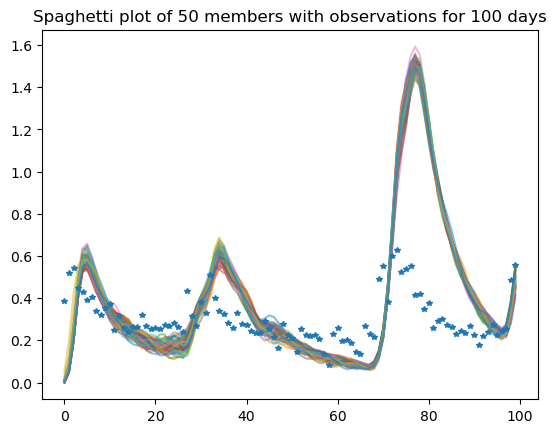

In [81]:
fig, ax = plt.subplots()
ax.set_title(f"Spaghetti plot of {n_particles} members with observations for 100 days")
# ax.plot(df.Q.iloc[:n_days].values,marker="*",lw=0,zorder=10,ms=4)
ax.plot(df.Q.iloc[:n_days].values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(ensembleMember.Q_m_list,alpha=0.5) for ensembleMember in ensemble];
# ax.set_ylim(0,10)

In [71]:
Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])
lst_NSE = np.array([calc_NSE(df.Q.iloc[:n_days], Qm.flatten()) for Qm in Q_all])

In [72]:
# lst_NSE

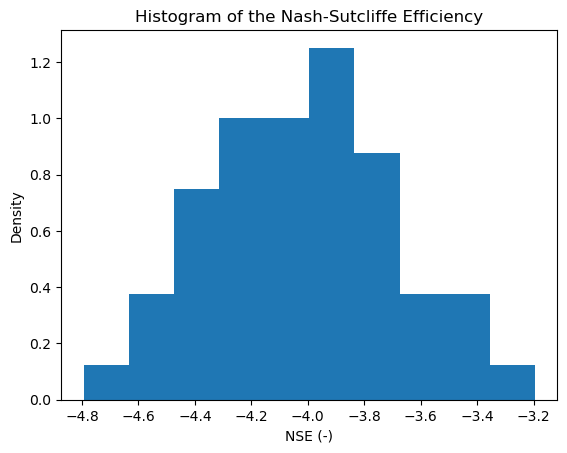

In [73]:
plt.hist(lst_NSE,density=True)
plt.title("Histogram of the Nash-Sutcliffe Efficiency")
plt.ylabel("Density")
plt.xlabel("NSE (-)");